In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

I earlier used polars, but I noticed it's too much of a hassle to use since its not natively supported by CatBoost and LightGBM, so I dropped it and switched back to pandas because anyways I had to convert the dataframe back to pandas when training so that kind of defeated the whole purpose of selecting polars. 

You can visit earlier versions if interested in polars. Thanks for the support!

In [83]:
# not using this anymore
# import polars as pl
import pandas as pd

We will follow a traditional machine learning workflow for this data as well which is as follows:

EDA -> any trasnformations in X -> (CatBoost and LightGBM models) -> predict -> create submission


## Reading test and train csv files and extracting ids from test for submission

In [ ]:
# change this back to kaggle path
# df = pd.read_csv("../data/calories-burnt-data/train.csv")
df = pd.read_csv("/kaggle/input/playground-series-s5e5/train.csv")
X,y = df.drop(columns=['Calories','id']), df['Calories']

In [ ]:
X_test = pd.read_csv("/kaggle/input/playground-series-s5e5/test.csv")
# X_test = pd.read_csv("../data/calories-burnt-data/test.csv")
ids = X_test['id']
X_test = X_test.drop(columns=['id'])

## EDA

In [14]:
X.head()

,Sex,Age,Height,Weight,Duration,Heart_Rate,Body_Temp
0,male,36,189.0,82.0,26.0,101.0,41.0
1,female,64,163.0,60.0,8.0,85.0,39.7
2,female,51,161.0,64.0,7.0,84.0,39.8
3,male,20,192.0,90.0,25.0,105.0,40.7
4,female,38,166.0,61.0,25.0,102.0,40.6


In [9]:
# polars is way faster and used less memory but can't use it in both the algorithms I have selected as explained at the start of the notebook.
X.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 750000 entries, 0 to 749999
Data columns (total 8 columns):
 #   Column      Non-Null Count   Dtype  
---  ------      --------------   -----  
 0   id          750000 non-null  int64  
 1   Sex         750000 non-null  object 
 2   Age         750000 non-null  int64  
 3   Height      750000 non-null  float64
 4   Weight      750000 non-null  float64
 5   Duration    750000 non-null  float64
 6   Heart_Rate  750000 non-null  float64
 7   Body_Temp   750000 non-null  float64
dtypes: float64(5), int64(2), object(1)
memory usage: 45.8+ MB


<Axes: >

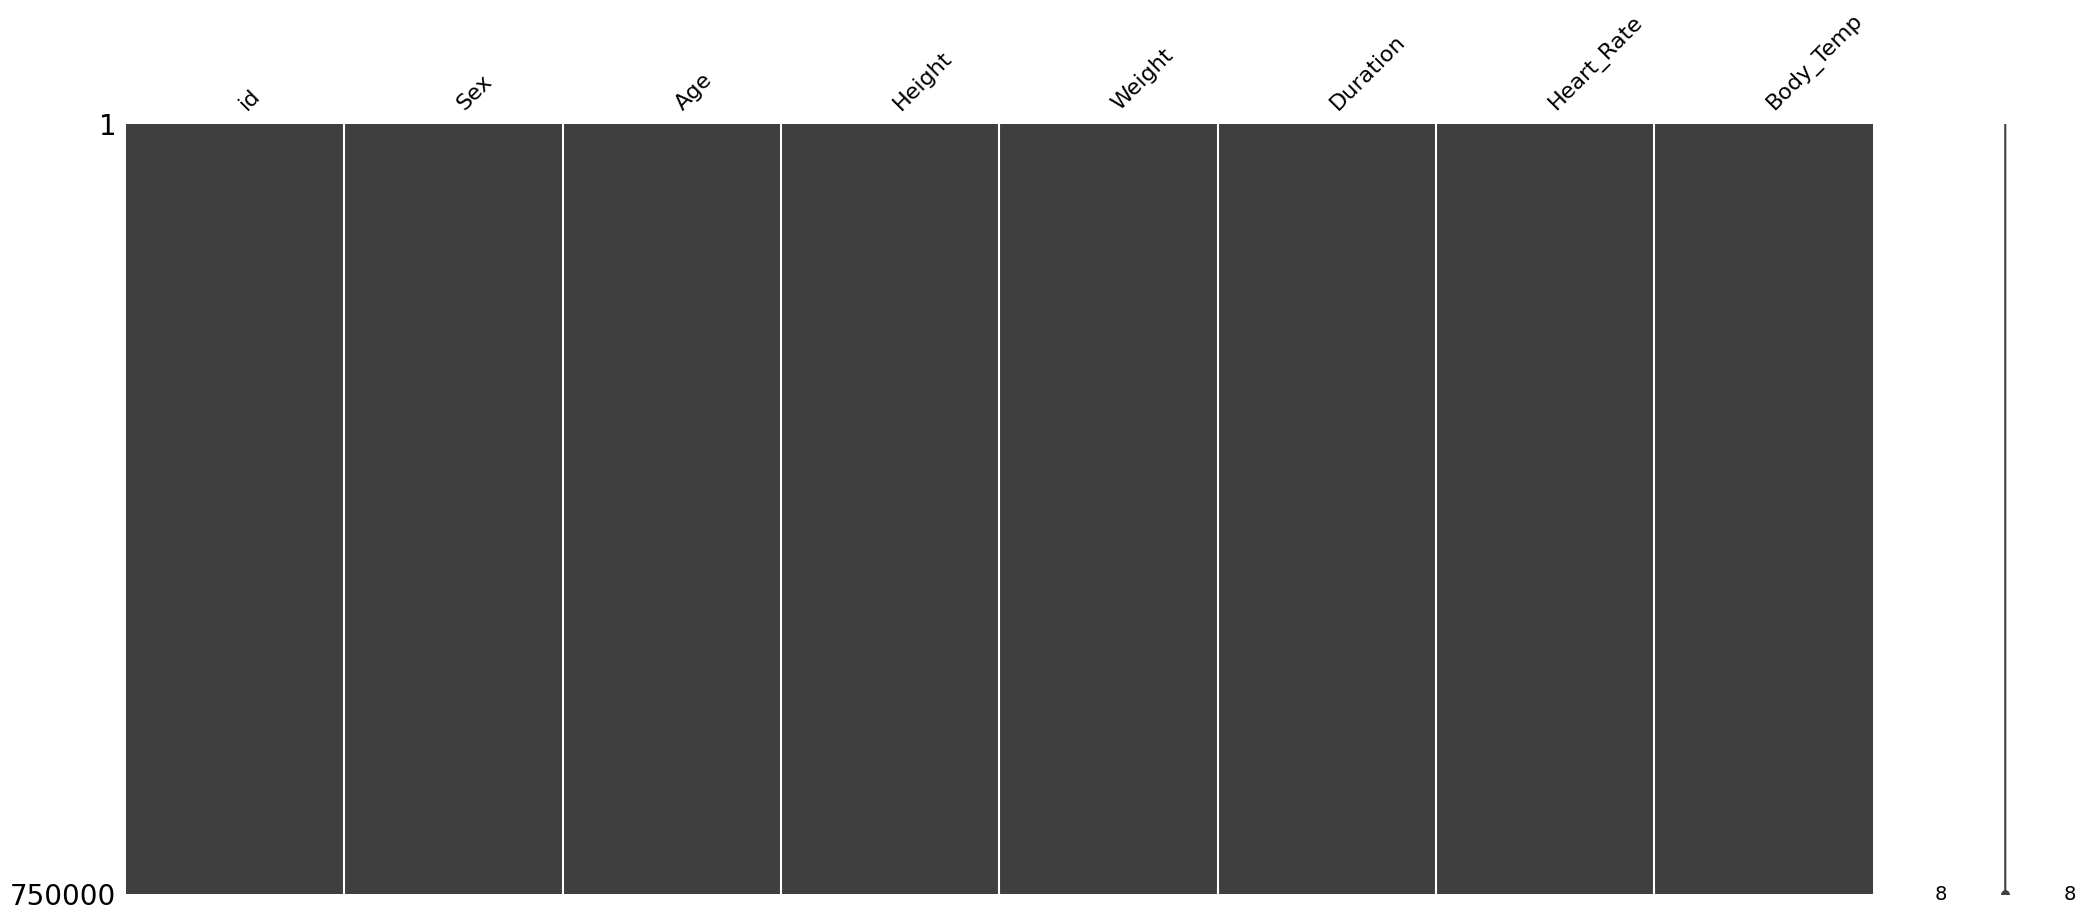

In [11]:
from missingno import matrix
matrix(X)
# no missing values as we can see here

### Converting the df into appropriate types we need them in 

- Since Sex is the only categorical variable we can simply convert it into category type.

- We have removed the id column from X since its not required to train the models.

In [63]:
# converting Sex to category type
X['Sex'] = X['Sex'].astype('category')
X_test['Sex'] = X_test['Sex'].astype('category')

# rest of the columns are already in the right type

### Plotting the data distributions for the columns

In [25]:
numerical_columns = X.select_dtypes(include=np.number).columns

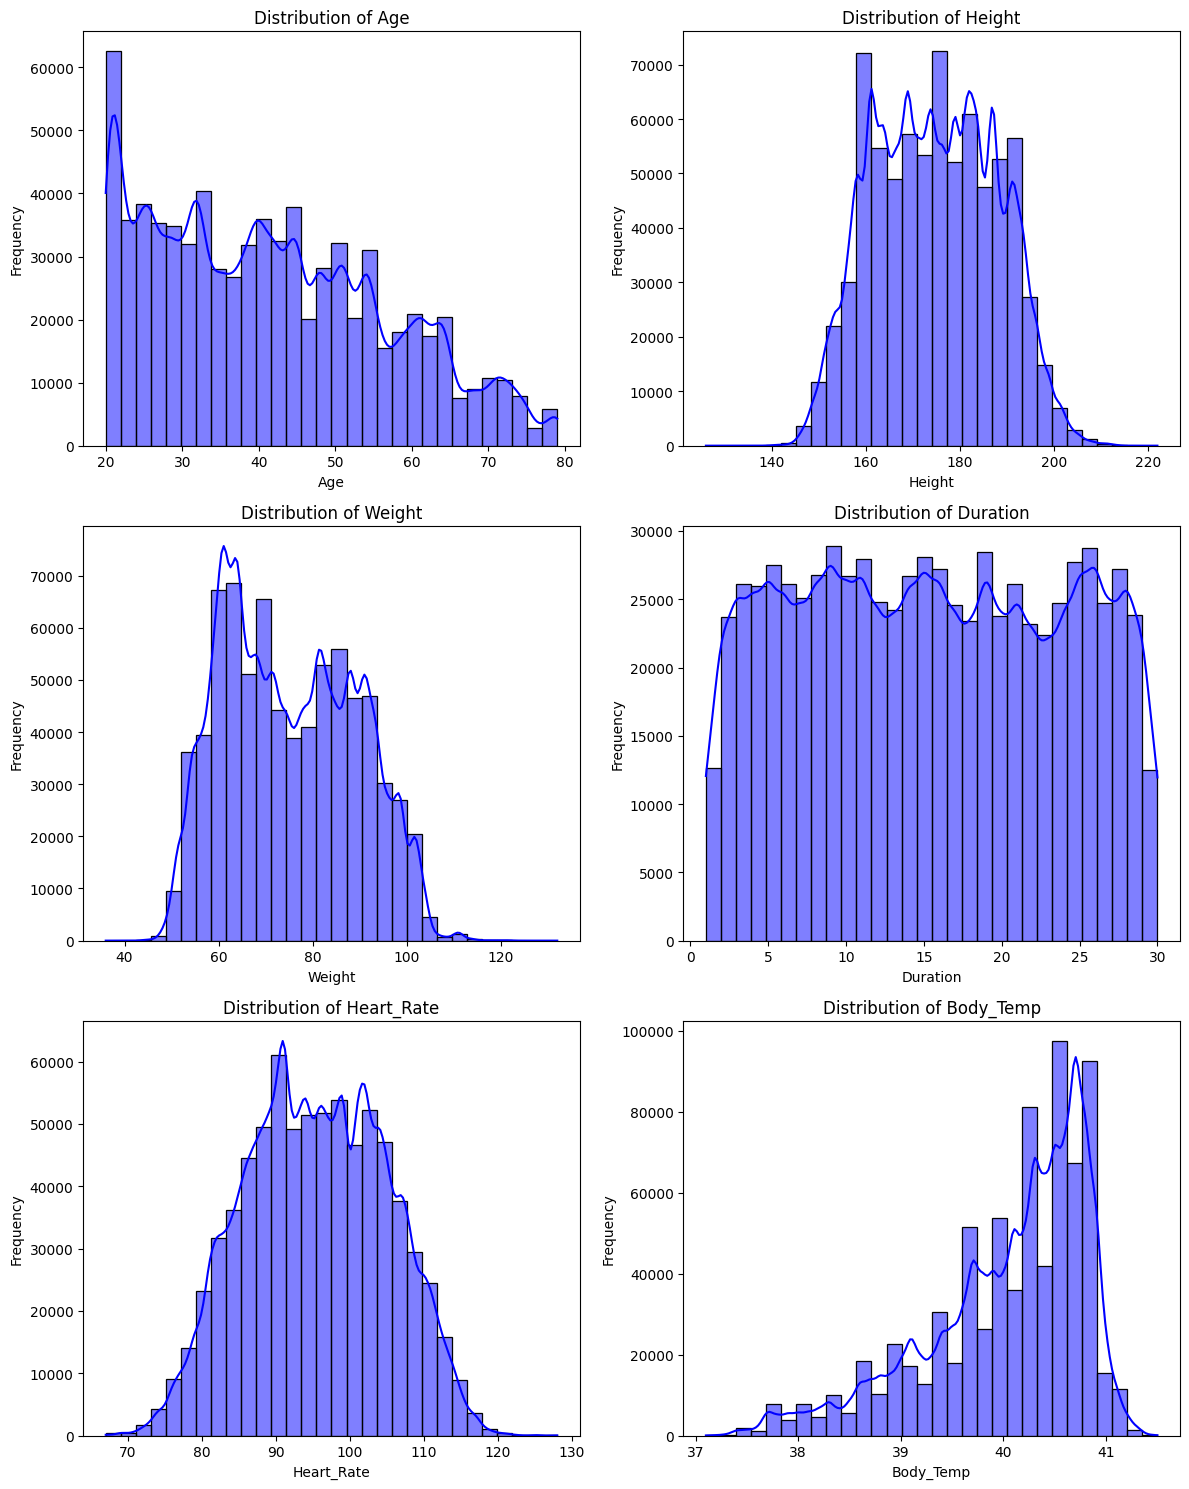

In [24]:
# THIS CODE WORKS I HAVE JUST COMMENTED IT OUT TO DECREASE THE RUN TIME IN KAGGLE ENVIRONMENT
# import seaborn as sns

# import matplotlib.pyplot as plt

# # Select numerical columns
# numerical_columns = X.select_dtypes(include=np.number).columns

# # Calculate the number of rows required for the grid
# num_cols = len(numerical_columns)
# num_rows = (num_cols + 1) // 2  # Two plots per row

# # Create a grid for plotting
# fig, axes = plt.subplots(num_rows, 2, figsize=(12, 5 * num_rows))
# axes = axes.flatten()

# # Plot each numerical column using seaborn
# for i, col in enumerate(numerical_columns):
#     sns.histplot(data=X, x=col, ax=axes[i], bins=30, kde=True, color='blue')
#     axes[i].set_title(f'Distribution of {col}')
#     axes[i].set_xlabel(col)
#     axes[i].set_ylabel('Frequency')

# # Hide any unused subplots
# for j in range(i + 1, len(axes)):
#     axes[j].set_visible(False)

# # Adjust layout
# plt.tight_layout()
# plt.show()

In [22]:
# get the skewness of the numerical columns
# Calculate and print skewness for each numerical column
skewness = X[numerical_columns].skew()
for col, skew in skewness.items():
    print(f"Skewness of {col}: {skew:.4f}")

Skewness of Age: 0.4364
Skewness of Height: 0.0518
Skewness of Weight: 0.2112
Skewness of Duration: 0.0263
Skewness of Heart_Rate: -0.0057
Skewness of Body_Temp: -1.0224


<Axes: xlabel='Sex'>

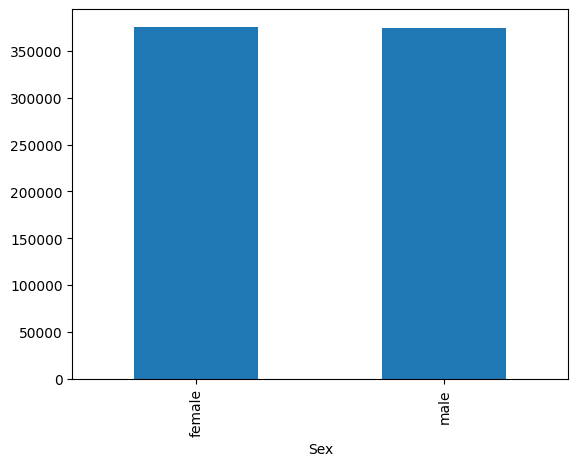

In [27]:
X['Sex'].value_counts().plot(kind='bar')

#### Insights

- Most of the columns are very close to normal distribution which can be a good thing we we were about to train using a parametric ML algorithm such as Multiple Linear Regression or Ridge Regression, but since we are using Tree Based methods, the distribution is a tad irrelevant here.
- The Sex columns are also quite balanced, so nothing much to do here as well, if they were imbalanced, we might have to visit under sampling or over sampling techniques to tackle that, not required here.

- ANOTHER THING TO NOTE IS WE DO NOT NEED TO PERFORM any transformations to our data, since we are using Tree Based algorithms. I did try to search some concrete answer, but could not come across any, it sort of heavily depends on the type of data, but we can try to experiment with and without transformation, we never know what might perform better. So I leave the transformation parts up to the reader, this notebook can be treated as a baseline for future implications and improvements.

<Axes: >

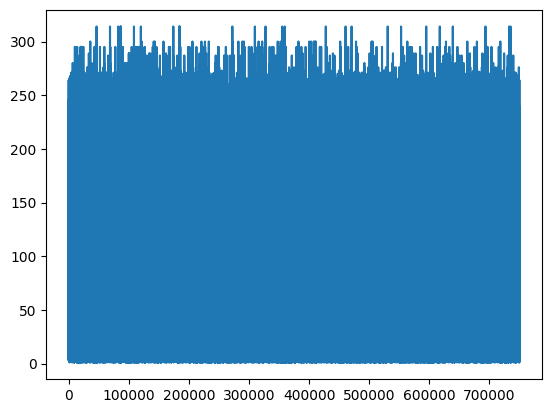

In [ ]:
# The plot does not really tell anything.
y.plot()

In [29]:
y.skew()

np.float64(0.539196264522959)

## Model Training

### CatBoost Baseline

The competition mentions that we will be using RMSLE as the metric for evaluation, since its not natively supported by CatBoost, we will implement it ourselves.

#### Below is an implementation of the RSMLE metric which is being used to train the model.

- For the first approach I used RSMLE with log1p (which under the hood calculates log(x+1)) and extracted max(0, y_pred) but I think this is sort of incorrect approach since we are changing the actual prediction with a much bigger value.

- For that reason I searched a bit and tried to stay as true to y_pred and created epsilon for negative and zero values, Although, max(0, epsilon) fixes the zero problem, but it does not fix the negative value since any negative value (inf,-1] still will be converted to epsilon, and that destroys the true representation of y_pred. This is just my thought and I wil be very excited to talk about this with someone having deeper knowledge of these things so ping me!

In [ ]:
# The CatBoostRegressor class is a gradient boosting algorithm that is particularly effective for categorical features.
# using log1p

import numpy as np

class RMSLEMetricLog1p(object):
    def get_final_error(self, error, weight):
        return np.sqrt(error / (weight + 1e-38))  # Prevent divide by zero

    def is_max_optimal(self):
        return False  # Lower RMSLE is better

    def evaluate(self, approxes, target, weight):
        assert len(approxes) == 1
        approx = approxes[0]
        assert len(target) == len(approx)

        error_sum = 0.0
        weight_sum = 0.0

        for i in range(len(approx)):
            y_pred = max(0.0, approx[i])
            y_true = max(0.0, target[i])

            log_pred = np.log1p(y_pred)
            log_true = np.log1p(y_true)
            error = (log_pred - log_true) ** 2

            w = 1.0 if weight is None else weight[i]
            error_sum += w * error
            weight_sum += w

        return error_sum, weight_sum


In [36]:
# using epsilon = 1e-5
class RMSLEMetric(object):
    def __init__(self, epsilon=1e-5):
        self.epsilon = epsilon

    def get_final_error(self, error, weight):
        # Prevent divide by zero
        return np.sqrt(error / (weight + 1e-38))

    def is_max_optimal(self):
        # Lower RMSLE is better if we want to get the max we return True
        return False

    def evaluate(self, approxes, target, weight):
        assert len(approxes) == 1
        approx = approxes[0]
        assert len(target) == len(approx)

        error_sum = 0.0
        weight_sum = 0.0

        for i in range(len(approx)):
            y_pred = approx[i]
            y_true = target[i]

            # Soft floor
            y_pred = max(y_pred, self.epsilon)
            y_true = max(y_true, self.epsilon)

            log_pred = np.log(y_pred)
            log_true = np.log(y_true)
            error = (log_pred - log_true) ** 2

            w = 1.0 if weight is None else weight[i]
            error_sum += w * error
            weight_sum += w

        return error_sum, weight_sum

I will use the epsilon one but feel free to use the other one as well.

Also, the loss fuction here is RSME not RMSLE since it is an eval_metric not our loss function

In [43]:
# we will use CatBoost to train the model and predict the values and submit.
# Everything is set to default and CatBoost is quite good at vanilla settings as well.

from catboost import CatBoostRegressor
reg = CatBoostRegressor(
    eval_metric=RMSLEMetric(),
    early_stopping_rounds=50,
    thread_count=-1
)

In [44]:
# for better performance we can use the GPU and convert the train and test data to catboost pool
from catboost import Pool
train_pool = Pool(
    X,
    y,
    cat_features=['Sex']
)

test_pool = Pool(
    X_test,
    cat_features=['Sex']
)

In [45]:
# reg.fit(X,
#     y=y,
#     cat_features = ['Sex'],
# )
reg.fit(
    train_pool
)

/home/kamesh/github-projects/kaggle-notebooks/.venv/lib/python3.11/site-packages/catboost/core.py:2321: UserWarning: Failed to import numba for optimizing custom metrics and objectives
  _check_train_params(params)


Learning rate set to 0.11653
0:	learn: 1.0052802	total: 877ms	remaining: 14m 36s
1:	learn: 0.9463701	total: 1.75s	remaining: 14m 33s
2:	learn: 0.8950423	total: 2.64s	remaining: 14m 37s
3:	learn: 0.8448754	total: 3.54s	remaining: 14m 40s
4:	learn: 0.8000877	total: 4.4s	remaining: 14m 35s
5:	learn: 0.7551307	total: 5.28s	remaining: 14m 34s
6:	learn: 0.7138871	total: 6.16s	remaining: 14m 33s
7:	learn: 0.6737777	total: 7.02s	remaining: 14m 30s
8:	learn: 0.6391561	total: 7.9s	remaining: 14m 30s
9:	learn: 0.6037650	total: 8.8s	remaining: 14m 30s
10:	learn: 0.5733140	total: 9.69s	remaining: 14m 31s
11:	learn: 0.5410877	total: 10.6s	remaining: 14m 29s
12:	learn: 0.5159439	total: 11.4s	remaining: 14m 29s
13:	learn: 0.4891176	total: 12.3s	remaining: 14m 27s
14:	learn: 0.4611965	total: 13.2s	remaining: 14m 28s
15:	learn: 0.4353014	total: 14.1s	remaining: 14m 27s
16:	learn: 0.4096953	total: 15s	remaining: 14m 26s
17:	learn: 0.3885579	total: 15.9s	remaining: 14m 25s
18:	learn: 0.3696765	total: 16.8

In [47]:
y_preds = reg.predict(test_pool)

In [ ]:
# its important here to check if the min value is greater than zero otherise we will get an error when submitting the predictions.
y_preds.min()

np.float64(0.531124259579002)

'CatBoostRegressor'

In [ ]:
def create_submission(y_preds,ids,model):
    # Create submission DataFrame for CatBoost (Score: 0.05930) Baseline model
    pd.DataFrame({
        'id': ids,
        'Calories': y_preds
    }).to_csv(f'submission_{model.__class__.__name__}.csv', index=False)


# using LightGBM

I am using LightGBM just to check its speed over CatBoost, since it is praised a lot for its at par performance with xgboost with less memory and faster training.

- There are two ways of training LightGBM model, one is its own lbg.train() and a wrapper around scikit-learn (lbg.Regressor()). I am using lgb.train(), you can read more about that here: https://lightgbm.readthedocs.io/en/stable/pythonapi/lightgbm.LGBMRegressor.html

In [56]:
X.head()

,Sex,Age,Height,Weight,Duration,Heart_Rate,Body_Temp
0,male,36,189.0,82.0,26.0,101.0,41.0
1,female,64,163.0,60.0,8.0,85.0,39.7
2,female,51,161.0,64.0,7.0,84.0,39.8
3,male,20,192.0,90.0,25.0,105.0,40.7
4,female,38,166.0,61.0,25.0,102.0,40.6


In [66]:
# custom method for RMSLE just like CatBoost
import numpy as np

def rmsle_eval_epsilon(preds, train_data, epsilon=1e-5):
    y_true = train_data.get_label()
    weight = train_data.get_weight()  # This returns None if no weights provided

    # Soft floor
    y_pred = np.maximum(preds, epsilon)
    y_true = np.maximum(y_true, epsilon)

    log_pred = np.log(y_pred)
    log_true = np.log(y_true)
    squared_log_error = (log_pred - log_true) ** 2

    if weight is not None:
        weighted_error = np.sum(weight * squared_log_error)
        weight_sum = np.sum(weight)
    else:
        weighted_error = np.sum(squared_log_error)
        weight_sum = len(y_true)

    rmsle = np.sqrt(weighted_error / (weight_sum + 1e-38))  # to avoid division by 0
    return 'rmsle', rmsle, False  # False = lower is better


In [76]:
import lightgbm as lgb
import numpy as np
# Create LightGBM dataset
train_data = lgb.Dataset(X, label=y)
test_data  = lgb.Dataset(X_test)

# Set parameters
params = {
    'objective': 'poisson',
    'metric':'None' # setting this to none, since we are using custom metric
}

# Train the model
model = lgb.train(
    params,
    train_data,
    feval=lambda preds, data: rmsle_eval_epsilon(preds, data, epsilon=1e-5),
    num_boost_round=1000,
)




[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.002898 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 358
[LightGBM] [Info] Number of data points in the train set: 750000, number of used features: 7
[LightGBM] [Info] Start training from score 4.480545


In [ ]:
# Predict
y_pred = model.predict(X_test)



(250000,)

In [ ]:
# this saves the lightgbm model
# create_submission(y_pred,ids,model)
# The score is not that good for this one

np.float64(1.0896399557359195)

In [82]:
# creating submission for the catboost model
create_submission(y_preds,ids,reg)

## Results and Insights: Calorie Prediction Using CatBoost and LightGBM 

This notebook explores calorie prediction using **CatBoost** and **LightGBM**, two powerful gradient boosting algorithms. 

Here's a summary of the workflow, results, and insights:

---

#### **Workflow Overview**
1. **EDA (Exploratory Data Analysis):**
   - Checked data distributions and skewness.
   - Converted the `Sex` column to a categorical type for compatibility with both models.
   - Observed that most numerical columns are close to a normal distribution, but transformations were not necessary due to the use of tree-based models.

2. **Model Training:**
   - **CatBoost:** Used a custom RMSLE metric for evaluation and trained the model with default settings. CatBoost's ability to handle categorical features natively made it a strong choice.
   - **LightGBM:** Trained using a custom RMSLE evaluation function. LightGBM was tested for its speed and memory efficiency compared to CatBoost.

3. **Evaluation Metric:**
   - RMSLE (Root Mean Squared Logarithmic Error) was used as the evaluation metric, as specified in the competition.

---

#### **Results**
- **CatBoost:** Achieved a baseline RMSLE score of **0.05930** with minimal tuning. The model performed well with its default settings, showcasing its robustness.
- **LightGBM:** While faster, the RMSLE score was not as competitive as CatBoost in this case. Further tuning might improve its performance.

---

#### **Insights**
1. **EDA Observations:**
   - The dataset was clean, with no missing values.
   - The `Sex` column was balanced, so no resampling techniques were required.
   - Tree-based models like CatBoost and LightGBM do not require feature scaling or transformations, simplifying preprocessing.

2. **Model Comparison:**
   - **CatBoost** performed better out of the box, especially with categorical data.
   - **LightGBM** was faster but required more tuning to match CatBoost's performance.

3. **Custom RMSLE Metric:**
   - Implemented two versions of RMSLE (log1p and epsilon-based). The epsilon-based approach was chosen for its ability to handle negative and zero predictions more effectively.

4. **Feature Engineering:**
   - Minimal feature engineering was required due to the nature of the dataset and the models used.

---

#### **Thanks for the Support!**
This notebook serves as a **baseline** for calorie prediction using tree-based models. Feel free to build upon it, experiment with hyperparameter tuning, or try other algorithms. If you found this helpful, please **upvote** and share your thoughts or improvements. Your support is greatly appreciated! 😊

#MachineLearning #CatBoost #LightGBM #GradientBoosting #DataScience #Kaggle #Python